In [1]:
#!TF_ENABLE_DEPRECATION_WARNINGS=1
import os
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense,Dropout,BatchNormalization,Activation
from pympler import asizeof
import gc
import sys
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet201

2024-01-01 15:36:30.057633: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 15:36:30.120568: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 15:36:31.059388: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# 加载 pickle 文件的函数
# 注意需要非常大的内存 实验使用了80G内存
def load_pickle_file(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

def load_pickle(number):
    # 初始化列表以存储数据
    x_data = []
    y_data = []
    # 遍历当前目录的文件
    for file in os.listdir('VideoFramePickle'):
        if file.endswith(f'_x_{number}.pickle'):
            print(f"filename ---{file}")
            # 直接加载 x 数据
            x = load_pickle_file(os.path.join('VideoFramePickle',file))
            x_data.append(x)
        elif file.endswith(f'_y_{number}.pickle'):
            print(f"filename ---{file}")
            # 直接加载 y 数据
            y = load_pickle_file(os.path.join('VideoFramePickle',file))
            y_data.append(y)
    return x_data,y_data


In [4]:
image_size=50
def process_data_for_model(x,y):
    # 合并所有的 x 和 y 数据
    # 注意需要非常大的内存 实验使用了80G内存
    x_all = np.concatenate(x, axis=0) if x else np.array([])
    # y_all = np.concatenate(y, axis=0) if y else np.array([])
    y_all = np.concatenate(y)
    images_array = np.array(x_all)
    x_all = images_array.reshape(-1, 10, image_size, image_size, 3)
    ## 释放部分内存
    del x
    del y
    del images_array
    print(x_all.shape)
    # print(len(y_all))
    ## 将60G数据分成5份之后，每一份大约12G左右
    print(asizeof.asizeof(x_all)/1024/1024/1024)
    ## 手动触发GC
    gc_count = gc.collect()
    # print(gc_count)
    return x_all,y_all



In [5]:
x_data,y_data = load_pickle(1)
x_all,y_all = process_data_for_model(x_data,y_data)

filename ---Neutral_x_1.pickle
filename ---Neutral_y_1.pickle
filename ---Happy_x_1.pickle
filename ---Happy_y_1.pickle
filename ---Fear_x_1.pickle
filename ---Fear_y_1.pickle
filename ---Anger_x_1.pickle
filename ---Anger_y_1.pickle
filename ---Sad_x_1.pickle
filename ---Sad_y_1.pickle
filename ---Disgust_x_1.pickle
filename ---Disgust_y_1.pickle
(56922, 10, 50, 50, 3)
3.9759561121463776


In [6]:
print(f"{len(x_data[0])} {len(x_data[1])} {len(x_data[2])} {len(x_data[3])} {len(x_data[4])} {len(x_data[5])}")

7906 8898 9577 9865 9896 10780


In [7]:
print(f"{len(y_data[0])} {len(y_data[1])} {len(y_data[2])} {len(y_data[3])} {len(y_data[4])} {len(y_data[5])}")

7906 8898 9577 9865 9896 10780


In [8]:
# 获取 y_all 的类别数，用于 one-hot 编码
num_classes = len(np.unique(y_all))
# 进行 one-hot 编码
y_all = to_categorical(y_all, num_classes)


In [9]:
## 归一化
x_all=x_all/255.0

In [10]:
# 获取输入数据的维度信息
time_steps, height, width, channels = x_all.shape[1:]
print(time_steps)
print(height)
print(width)
print(channels)

10
50
50
3


In [11]:
#保存文件，下次直接使用
# 单独保存每个数组到.npy文件
np.save('VideoFramePickle/x_all.npy', x_all)
np.save('VideoFramePickle/y_all.npy', y_all)

In [5]:
#直接加载文件
x_all = np.load('VideoFramePickle/x_all.npy')
y_all = np.load('VideoFramePickle/y_all.npy')

In [6]:
# 现在，可以使用来训练模型
x_train, x_second, y_train, y_second = train_test_split(x_all, y_all, test_size=0.1, random_state=42)

In [7]:
np.save('VideoFramePickle/x_train.npy', x_train)
np.save('VideoFramePickle/y_train.npy', y_train)

In [8]:
np.save('VideoFramePickle/x_test.npy', x_second)
np.save('VideoFramePickle/y_test.npy', y_second)

In [5]:
x_train = np.load('VideoFramePickle/x_train.npy')
y_train = np.load('VideoFramePickle/y_train.npy')

In [6]:
time_steps, height, width, channels = 10, 50, 50, 3
num_classes = 6

# 构建 CNN-BiLSTM 模型
model = Sequential()

# 加载 DenseNet201 模型，不包括顶层（即全连接层），使用预训练的权重
# 注意：DenseNet201 默认的输入尺寸是 224x224。在这里我们使用 50x50，这可能不是最优的。
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(height, width, channels))

# 将 DenseNet201 作为 TimeDistributed 层添加到模型中
model.add(TimeDistributed(base_model, input_shape=(time_steps, height, width, channels)))

# 对特征图进行扁平化处理，为序列处理层准备
model.add(TimeDistributed(Flatten()))

# 添加双向 LSTM 层来处理时间序列，这里不返回序列，只返回最后一个输出
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))

# 添加全连接层
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

# 添加全连接层输出最终预测，使用 softmax 函数进行多类分类
model.add(Dense(units=num_classes, activation='softmax'))

# 编译模型
LR = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# 打印模型结构
model.summary()

2024-01-01 15:36:58.119197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 1, 1, 1920)    18321984  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 1920)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 200)               1616800   
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [7]:
# 配置模型检查点
checkpoint = ModelCheckpoint(
    'CNNBiLSTM_epoch_{epoch:02d}.h5',  # 文件路径，其中{epoch:02d}是格式化字符串，用于在文件名中包含epoch编号
    monitor='val_accuracy',            # 可以是'val_loss', 'val_accuracy', 'loss', 'accuracy'等
    verbose=1,                        # 日志显示模式，0或1
    save_best_only=False,             # 如果设置为True，则只保存在验证集上性能最好的模型
    save_weights_only=False,          # 如果设置为True，则只保存模型的权重，如果为False，则保存整个模型
    mode='auto',                      # 可以是'auto', 'min', 'max'，决定了监控指标是应该最大化还是最小化
    save_freq='epoch'                 # 检查点之间的间隔（每个epoch）
)
history = model.fit(
    x_train, y_train, 
    epochs=20, 
    batch_size=10, 
    # validation_data=(x_val, y_val),
    validation_split=0.6,
    callbacks=[checkpoint],
    verbose=1,
    workers=128,
    shuffle=True
)

Epoch 1/20


2024-01-01 15:38:07.443308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-01 15:38:09.410932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-01 15:38:09.439523: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x888ae90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-01 15:38:09.439579: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-01 15:38:09.449970: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-01 15:38:09.624679: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proces

2050/2050 [==============================] - ETA: 0s - loss: 1.3045 - accuracy: 0.4818
Epoch 1: saving model to CNNBiLSTM_epoch_01.h5


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2050/2050 [==============================] - 510s 194ms/step - loss: 1.3045 - accuracy: 0.4818 - val_loss: 1.0062 - val_accuracy: 0.6180
Epoch 2/20
2050/2050 [==============================] - ETA: 0s - loss: 0.9525 - accuracy: 0.6427
Epoch 2: saving model to CNNBiLSTM_epoch_02.h5
2050/2050 [==============================] - 360s 176ms/step - loss: 0.9525 - accuracy: 0.6427 - val_loss: 0.8627 - val_accuracy: 0.6781
Epoch 3/20
2050/2050 [==============================] - ETA: 0s - loss: 0.7909 - accuracy: 0.7136
Epoch 3: saving model to CNNBiLSTM_epoch_03.h5
2050/2050 [==============================] - 352s 172ms/step - loss: 0.7909 - accuracy: 0.7136 - val_loss: 0.7582 - val_accuracy: 0.7165
Epoch 4/20
2050/2050 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7514
Epoch 4: saving model to CNNBiLSTM_epoch_04.h5
2050/2050 [==============================] - 352s 172ms/step - loss: 0.6868 - accuracy: 0.7514 - val_loss: 0.7730 - val_accuracy: 0.7210
Epoch 5/20
2050/2

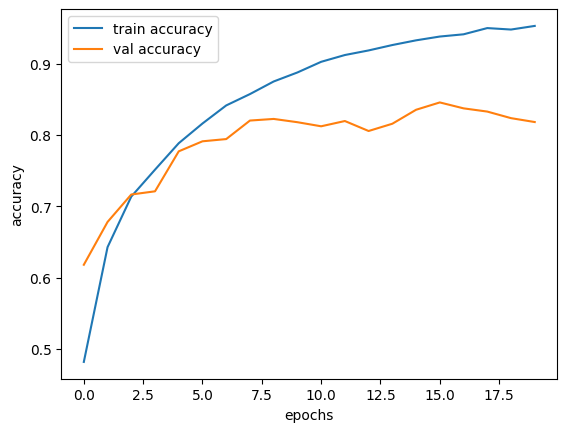

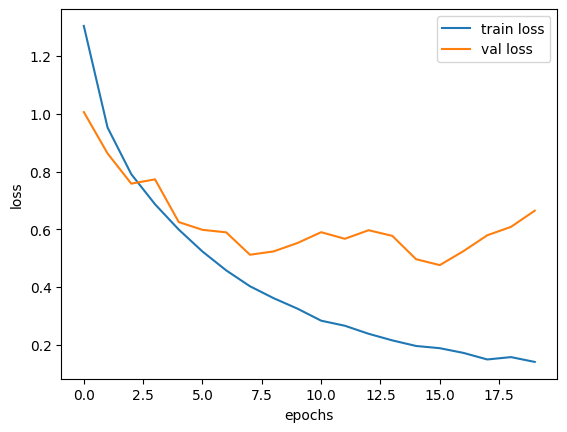

In [9]:
import matplotlib.pyplot as plt
epochs = list(range(20))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
model=tf.keras.models.load_model("CNNBiLSTM_epoch_16.h5")
x_test = np.load('VideoFramePickle/x_test.npy')
y_test = np.load('VideoFramePickle/y_test.npy')
loss,acc = model.evaluate(x_test,y_test)
print(f"loss {loss},acc {acc}")

178/178 [==============================] - 10s 31ms/step - loss: 0.4728 - accuracy: 0.8472
loss 0.47283199429512024,acc 0.8471807241439819
